# Implement Homotopy LARS

In [1]:
import numpy as np

def homotopy_LARS(A, y):
    # LARS algo for LASSO path (aka homotopy LARS for LASSO,
    # in constrast to forward variable selection LARS)
    m, n = A.shape

    # start with 0 model
    x = np.zeros((n, 1))

    # calculate correlation of variables with responses
    # to determine variable with largest correlation
    c0 = A.T @ y
    
    # equicorrelation variables set
    I = [np.argmax(np.abs(c0))]

    # equicorrelation signs set
    s = np.zeros_like(x)
    s[I] = np.sign(c0[I])

    # calculate emperical covariance matrix
    ATA = A.T @ A

    # # see eqn (5) of "The Lasso Problem and Uniqueness" (TLPU)
    # s[I] = np.sign(c0 - ATA @ x[I])

    # linear factors as defined in eqn (15) of TLPU
    # needs to be pre-allocated because crossing time
    # calculation depends on indexing a full vector
    # as opposed to a variable length set
    c = np.zeros_like(x)
    d = np.zeros_like(x)

    # set regularization parameter lambda = infty
    lambda_ = np.abs(c0).max()

    # initialize iterate
    # k = 0

    # initialize solution list
    xs = []

    # initialize list to hold LASSO parameter path
    lambdas = [lambda_]

    # create CONST set of integers from 1 to n
    i_set = set(range(n))

    # while lambda > 0
    while lambda_ > 0:

        ## step 1: compute LARS lasso solution at lambda_k by least squares
        ## (i.e. KKT stationarity condition for lasso)

        # update model at equicorrelated variables as seen in eqn (15) of TLPU
        c[I] = np.linalg.pinv(A[:,I]) @ y
        d[I] = np.linalg.pinv(A[:,I].T @ A[:,I]) @ s[I]

        # update model at equicorrelated variables as seen in eqn (15) of TLPU
        x = c - lambda_*d
        print('x: ', x)

        ## step 2: compute next joining time
        # needs to be transposed because weird matrix calculation thing
        t_join_p = (ATA[:,I] @ c[I] - c0)/(ATA[:,I] @ d[I] + 1)
        t_join_m = (ATA[:,I] @ c[I] - c0)/(ATA[:,I] @ d[I] - 1)

        # vectorized calculation of t_join (multiplication gives AND)
        t_join = np.where((np.zeros_like(t_join_p) <= t_join_p)   * (t_join_p <= lambda_*np.ones_like(t_join_p)),\
                          t_join_p, t_join_m)
        print(t_join)
        # calculate inactive set
        Ic = list(i_set - set(I))

        # calculate next joining time (eqn (17) from TLPU
        # on a typical iteration, the try block will run
        # on the occasion all of the variables have been
        # already been added to the equicorrelation set,
        # we want to directly choose the crossing variables
        try:
          lambda_join = t_join[Ic].max()
          # calculate next joining variable
          join_var = [np.argwhere(t_join==lambda_join)[0,0]]
          # print('first join_var: ', join_var)

          # calculate next joining sign
          s_join = np.sign(c0[join_var] - A[:,join_var].T @ A @ (c - lambda_join*d))
          # print(s_join)
        except:
          # as lambda_ is a non-negative scalar,
          # 0 is a guaranteed lower bound
          lambda_join = 0
        print('lambda_join:', lambda_join)

        ## step 3: compute next crossing time

        # as seen in TLPU in line above eqn (19)
        lambda_ratio = c/d

        # print('lambda_ratio: ', lambda_ratio)

        # vectorized calculation of t_cross (multiplication gives AND)
        # numerical instability and rounding forces us to take epsilon off
        t_cross = np.where((np.zeros_like(lambda_ratio) <= lambda_ratio) *\
                           (lambda_ratio <= (lambda_ - np.finfo(np.float32).eps)*np.ones_like(lambda_ratio)),\
                          lambda_ratio, np.zeros_like(lambda_ratio))
        # print('t_cross: ', t_cross)

        # calculate next crossing time eqn(20) in TLPU
        lambda_cross = t_cross[I].max()

        # calculate next crossing variable
        cross_var = [np.argwhere(t_cross==lambda_cross)[0,0]]

        # calculate next crossing sign
        s_cross = s[cross_var]

        ## step 4: set lambda_{k+1} and adjust equicorrelation set accordingly
        
        if lambda_join > lambda_cross:

            # update lambda w/ lambda_join
            lambda_ = lambda_join

            # add joining variable to equicorrelation set
            I.append(join_var[0])
            I = list(set(I))

            # add joining sign to equicorrelation signs
            s[join_var] = s_join

        else:

            # update lambda w/ lambda_cross
            lambda_ = lambda_cross

            # remove crossing variable from equicorrelation set
            I.remove(cross_var)

            # remove crossing signs from equicorrelation signs
            s[cross_var] = 0

        # append solution x to solution list before updating solution x
        xs.append(x.copy())

        # append regularization parameter to lasso path list before updating lambda
        lambdas.append(lambda_)
        
        # update k = k + 1
        # k += 1

    return np.array(xs).squeeze(), lambdas

# Compare with off-the-shelf methods

x:  [[0.00000000e+00]
 [0.00000000e+00]
 [5.68434189e-13]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[[1.57632531e+02]
 [1.28548809e+01]
 [2.27373675e-13]
 [5.61245442e+02]
 [1.41433974e+02]
 [4.57759791e+01]
 [4.59392050e+02]
 [5.18600947e+02]
 [8.89315991e+02]
 [4.09272275e+02]]
lambda_join: 889.3159907349723
lambda_ratio:  [[         nan]
 [         nan]
 [949.43526038]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]]
t_cross:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
x:  [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 6.01192696e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.27373675e-13]
 [ 0.00000000e+00]]
[[   18.58076033]
 [   70.40151957]
 [    0.        ]
 [  452.90096891]
 [   93.10231159]
 [   64.4626143 ]
 [  311.03340805]
 [  131.12584042]
 [-1536.        ]

<ipython-input-1-7ccc1318f7d5>:99: RuntimeWarning: invalid value encountered in true_divide
  lambda_ratio = c/d
<ipython-input-1-7ccc1318f7d5>:66: RuntimeWarning: divide by zero encountered in true_divide
  t_join_p = (ATA[:,I] @ c[I] - c0)/(ATA[:,I] @ d[I] + 1)
<ipython-input-1-7ccc1318f7d5>:67: RuntimeWarning: divide by zero encountered in true_divide
  t_join_m = (ATA[:,I] @ c[I] - c0)/(ATA[:,I] @ d[I] - 1)
<ipython-input-1-7ccc1318f7d5>:67: RuntimeWarning: invalid value encountered in true_divide
  t_join_m = (ATA[:,I] @ c[I] - c0)/(ATA[:,I] @ d[I] - 1)
<ipython-input-2-426e771473a0>:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  rgr_lasso.fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python

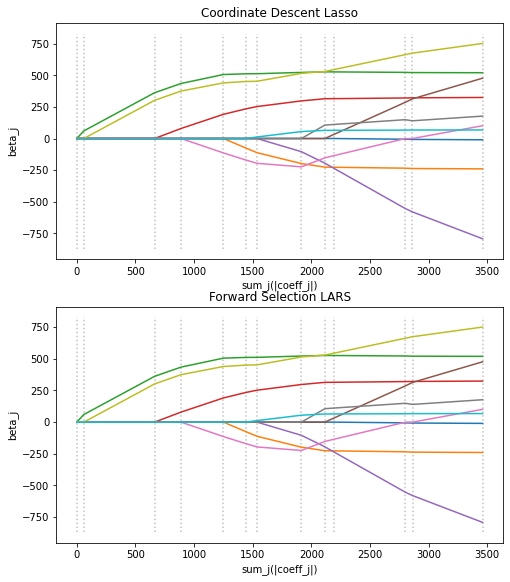

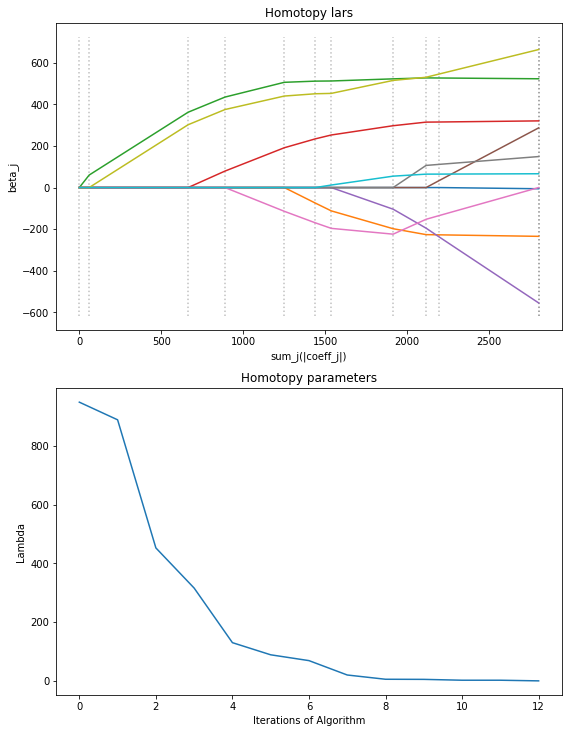

In [2]:
from sklearn.linear_model import Lasso, lars_path, LassoLars
from sklearn import datasets
import matplotlib.pyplot as plt

# load data
X, y = datasets.load_diabetes(return_X_y=True)
y = y[...,None]

# LARS (w/o) lasso
lars_alphas, _, lars_coef = lars_path(X, y.squeeze(), method='lasso')
csum_lars = np.sum(abs(lars_coef.T), axis=1)

# homotopy LARS
h_alphas, lambdas = homotopy_LARS(X, y)
csum_h_alphas = np.sum(abs(h_alphas), axis=1)

# lasso (coordinate descent)
ws = np.zeros((X.shape[1], len(lars_alphas)))
for i, alpha in enumerate(lars_alphas):
    rgr_lasso = Lasso(alpha=alpha)
    rgr_lasso.fit(X, y)
    ws[:,i] = rgr_lasso.coef_
csum_lasso = np.sum(abs(ws.T), axis=1)

# lasso LARS
c_lassoLARS = np.array([LassoLars(alpha = a).fit(X,y).coef_ for a in lars_alphas])
csum_lassoLARS = np.sum(abs(c_lassoLARS), axis = 1)

nr = 4

plt.figure(figsize=(8,20))

plt.subplot(nr,1,1)
plt.plot(csum_lasso, ws.T)
ymin, ymax = plt.ylim()
plt.vlines(csum_lasso, ymin, ymax, linestyle = "dotted", alpha = 0.25)
plt.ylabel('beta_j')
plt.xlabel('sum_j(|coeff_j|)')
plt.title('Coordinate Descent Lasso')

plt.subplot(nr,1,2)
plt.plot(csum_lars, lars_coef.T)
ymin, ymax = plt.ylim()
plt.vlines(csum_lars, ymin, ymax, linestyle = "dotted", alpha = 0.25)
plt.ylabel('beta_j')
plt.xlabel('sum_j(|coeff_j|)')
plt.title('Forward Selection LARS')

plt.figure(figsize=(8,20))

# plt.subplot(nr,1,3)
# plt.plot(csum_lassoLARS, c_lassoLARS)
# ymin, ymax = plt.ylim()
# plt.vlines(csum_lassoLARS, ymin, ymax, linestyle = "dotted", alpha = 0.25)
# plt.ylabel('beta_j')
# plt.xlabel('sum_j(|coeff_j|)')
# plt.title("LassoLARS")

plt.subplot(nr,1,1)
plt.plot(csum_h_alphas, h_alphas)
ymin, ymax = plt.ylim()
plt.vlines(csum_h_alphas, ymin, ymax, linestyle = "dotted", alpha = 0.25)
plt.ylabel('beta_j')
plt.xlabel('sum_j(|coeff_j|)')
plt.title('Homotopy lars')

plt.subplot(nr,1,2)
plt.plot(lambdas)
plt.ylabel('Lambda')
plt.xlabel('Iterations of Algorithm')
plt.title('Homotopy parameters')

# if n < m:
#     plt.suptitle('Fat X')
#     plt.savefig('lasso_fat.png')
# else:
#     plt.suptitle('Thin X')
#     plt.savefig('lasso_thin.png')

plt.tight_layout()
plt.show()